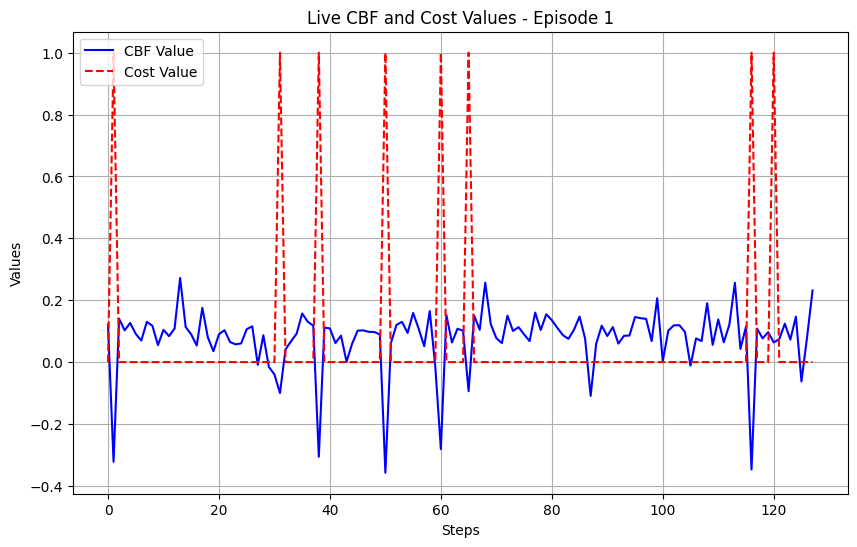

Episode 1 finished!
Simulation finished after 1 episodes.


In [89]:
##THIS IS FOR USING DATASET TO LOAD TRAJECTORIES AND USING COST FROM DATASET
##gd idk why

#OfflineSwimmerVelocityGymnasium CONTAINS COST IN THE INFO. SafetySwimmerVelocity does not
#OfflineSwimmerVelocityGymnasium CONTAINS COST IN THE INFO. SafetySwimmerVelocity does not
import torch
import json
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from IPython.display import display, clear_output
import time
from torch.utils.data import DataLoader
from osrl.common.exp_util import seed_all

# Assuming these imports are correct and the modules are available
from network_ihab import CombinedCBFDynamics
from dataset_ihab import TransitionDataset

#892 and 449 are good 126 is good
##126 is v gd
# Load model and hyperparameters
model_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_449/combined_model.pth"
hyperparams_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_449/hyperparameters.json"

seed_all(112)

# Load hyperparameters
with open(hyperparams_path, 'r') as f:
    hyperparams = json.load(f)


# Initialize and load the model
combinedcbfdynamics = CombinedCBFDynamics(
    num_action=hyperparams['num_action'],
    state_dim=hyperparams['state_dim'],
    cbf_hidden_dim=hyperparams['cbf_hidden_dim'],
    dynamics_hidden_dim=hyperparams['dynamics_hidden_dim'],
    cbf_num_layers=hyperparams['cbf_num_layers'],
    dynamics_num_layers=hyperparams['dynamics_num_layers'],
    dt=hyperparams['dt']
)

checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
combinedcbfdynamics.load_state_dict(checkpoint)
combinedcbfdynamics.eval()
print("Model loaded successfully!")

# Initialize environment
env = gym.make('OfflineSwimmerVelocityGymnasium-v1')
dataset = env.get_dataset()

# Process dataset (assuming these functions are defined elsewhere)
# env.set_target_cost(args.cost_limit)
# process_bc_dataset(dataset, args.cost_limit, args.gamma, args.bc_mode)

# Create a dataset and dataloader
dataset = TransitionDataset(dataset,split='train')
dataloader = DataLoader(dataset, batch_size=128)

# Get a batch of data
batch = next(iter(dataloader))
observations, next_observations, actions, _, costs, done = [b.to(torch.float32) for b in batch]

# Use the model to predict next states
with torch.no_grad():
    predicted_next_observations = combinedcbfdynamics.forward_next_state(observations, actions)
    cbf_values_batch = combinedcbfdynamics.forward_cbf(observations)

print("Sample observations:", observations[:5])
print("Sample CBF values:", cbf_values_batch[:5])
print("Sample costs:", costs[:5])

# Initialize data storage for plotting
cbf_values = []
cost_values = []
steps = []
episode_count = 0
max_episodes = 1

observation, info = env.reset(seed=112)

while episode_count < max_episodes :
    for step_index in range(len(observations)):
        observation = observations[step_index].numpy()
        action = actions[step_index].numpy()

        # Compute CBF value
        obs_tensor = torch.FloatTensor(observation).unsqueeze(0)
        with torch.no_grad():
            cbf_value = combinedcbfdynamics.forward_cbf(obs_tensor).item()

        # Step in the environment
        _, _, terminated, truncated, _ = env.step(action)

        # Store history
        cbf_values.append(cbf_value)
        cost = costs[step_index].item()  # Use the cost from the dataset
        cost_values.append(cost)
        steps.append(step_index)

        # Update the plot dynamically
        clear_output(wait=True)
        
        plt.figure(figsize=(10, 6))
        plt.plot(steps, cbf_values, 'b-', label="CBF Value")
        plt.plot(steps, cost_values, 'r--', label="Cost Value")
        plt.xlabel('Steps')
        plt.ylabel('Values')
        plt.title(f'Live CBF and Cost Values - Episode {episode_count + 1}')
        plt.legend()
        plt.grid(True)
        display(plt.gcf())
        plt.close()

        # time.sleep(0.1)

        if terminated or truncated:
            break

    episode_count += 1
    print(f"Episode {episode_count} finished!")
    observation, info = env.reset()

print(f"Simulation finished after {episode_count} episodes.")
env.close()


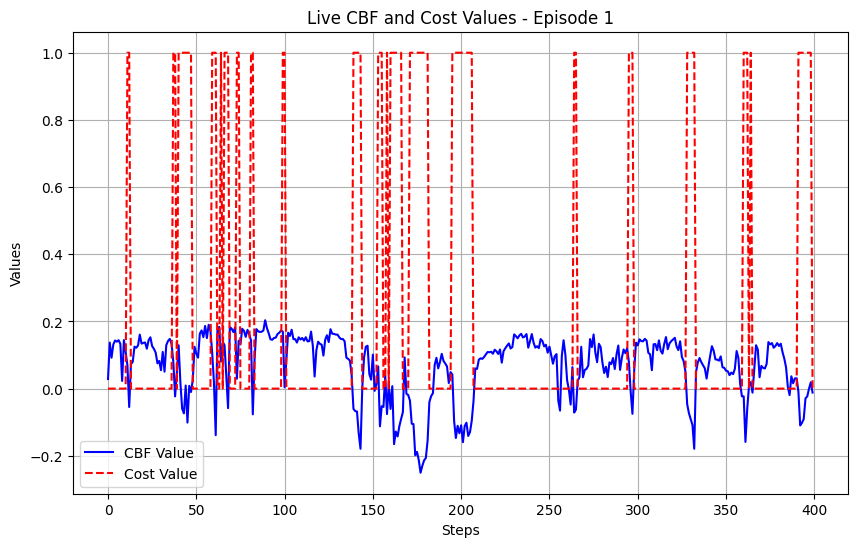

Episode 1 finished!
Simulation finished after 1 episodes.


In [38]:

##gd idk why
##USING DATASET TO LOAD DATA THEN COST IS FROM ENV
import torch
import json
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from IPython.display import display, clear_output
import time
from torch.utils.data import DataLoader
from osrl.common.exp_util import seed_all

# Assuming these imports are correct and the modules are available
from network_ihab import CombinedCBFDynamics
from dataset_ihab import TransitionDataset

# Load model and hyperparameters
model_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_645/combined_model.pth"
hyperparams_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_645/hyperparameters.json"

seed_all(112)

# Load hyperparameters
with open(hyperparams_path, 'r') as f:
    hyperparams = json.load(f)

# Initialize and load the model
combinedcbfdynamics = CombinedCBFDynamics(
    num_action=hyperparams['num_action'],
    state_dim=hyperparams['state_dim'],
    cbf_hidden_dim=hyperparams['cbf_hidden_dim'],
    dynamics_hidden_dim=hyperparams['dynamics_hidden_dim'],
    cbf_num_layers=hyperparams['cbf_num_layers'],
    dynamics_num_layers=hyperparams['dynamics_num_layers'],
    dt=hyperparams['dt']
)

checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
combinedcbfdynamics.load_state_dict(checkpoint)
combinedcbfdynamics.eval()
print("Model loaded successfully!")

# Initialize environment

env = gym.make('OfflineSwimmerVelocityGymnasium-v1')
dataset = env.get_dataset()

# Process dataset (assuming these functions are defined elsewhere)
# env.set_target_cost(args.cost_limit)
# process_bc_dataset(dataset, args.cost_limit, args.gamma, args.bc_mode)

# Create a dataset and dataloader
dataset = TransitionDataset(dataset,split='val')
dataloader = DataLoader(dataset, batch_size=400)##change this to make it longer

# Get a batch of data
batch = next(iter(dataloader))
observations, next_observations, actions, _, costs, done = [b.to(torch.float32) for b in batch]

# Use the model to predict next states
with torch.no_grad():
    predicted_next_observations = combinedcbfdynamics.forward_next_state(observations, actions)
    cbf_values_batch = combinedcbfdynamics.forward_cbf(observations)

print("Sample observations:", observations[:5])
print("Sample CBF values:", cbf_values_batch[:5])
print("Sample costs:", costs[:5])

# Initialize data storage for plotting
cbf_values = []
cost_values = []
steps = []
episode_count = 0
max_episodes = 1

observation, info = env.reset(seed=112)

while episode_count < max_episodes:
    for step_index in range(len(observations)):
        observation = obs_next
        action = actions[step_index].numpy()

        # Compute CBF value
        obs_tensor = torch.FloatTensor(observation).unsqueeze(0)
        with torch.no_grad():
            cbf_value = combinedcbfdynamics.forward_cbf(obs_tensor).item()

        # Step in the environment
        obs_next, reward, terminated, truncated, info = env.step(action)###USING ACTUAL OBSERVATION#USING ACTUAL OBSERVATION#USING ACTUAL OBSERVATION#USING ACTUAL OBSERVATION#USING ACTUAL OBSERVATION#USING ACTUAL OBSERVATION#USING ACTUAL OBSERVATION

        # Store history
        cbf_values.append(cbf_value)
        cost = info['cost']  # Use the cost from info of simulator
        cost_values.append(cost)
        steps.append(step_index)

        # Update the plot dynamically
        clear_output(wait=True)
        plt.figure(figsize=(10, 6))
        plt.plot(steps, cbf_values, 'b-', label="CBF Value")
        plt.plot(steps, cost_values, 'r--', label="Cost Value")
        plt.xlabel('Steps')
        plt.ylabel('Values')
        plt.title(f'Live CBF and Cost Values - Episode {episode_count + 1}')
        plt.legend()
        plt.grid(True)
        display(plt.gcf())
        plt.close()

        # time.sleep(0.1)

        if terminated or truncated:
            break

    episode_count += 1
    print(f"Episode {episode_count} finished!")
    observation, info = env.reset()

print(f"Simulation finished after {episode_count} episodes.")
env.close()


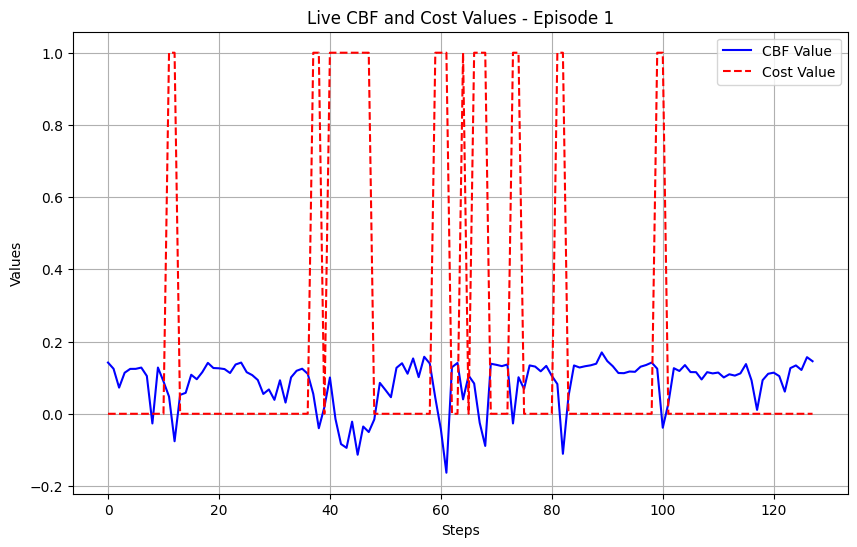

Episode 1 finished!
Simulation finished after 1 episodes.


In [9]:

##gd idk why
import torch
import json
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from IPython.display import display, clear_output
import time
from torch.utils.data import DataLoader
from osrl.common.exp_util import seed_all

# Assuming these imports are correct and the modules are available
from network_ihab import CombinedCBFDynamics
from dataset_ihab import TransitionDataset

# Load model and hyperparameters
model_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_217/combined_model.pth"
hyperparams_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_217/hyperparameters.json"

seed_all(112)

# Load hyperparameters
with open(hyperparams_path, 'r') as f:
    hyperparams = json.load(f)

# Initialize and load the model
combinedcbfdynamics = CombinedCBFDynamics(
    num_action=hyperparams['num_action'],
    state_dim=hyperparams['state_dim'],
    cbf_hidden_dim=hyperparams['cbf_hidden_dim'],
    dynamics_hidden_dim=hyperparams['dynamics_hidden_dim'],
    cbf_num_layers=hyperparams['cbf_num_layers'],
    dynamics_num_layers=hyperparams['dynamics_num_layers'],
    dt=hyperparams['dt']
)

checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
combinedcbfdynamics.load_state_dict(checkpoint)
combinedcbfdynamics.eval()
print("Model loaded successfully!")

# Initialize environment
env = gym.make('OfflineSwimmerVelocityGymnasium-v1')
dataset = env.get_dataset()
# env = gym.make('SafetySwimmerVelocityGymnasium-v1')

# Process dataset (assuming these functions are defined elsewhere)
# env.set_target_cost(args.cost_limit)
# process_bc_dataset(dataset, args.cost_limit, args.gamma, args.bc_mode)

# Create a dataset and dataloader
dataset = TransitionDataset(dataset,split='val')
dataloader = DataLoader(dataset, batch_size=128)

# Get a batch of data
batch = next(iter(dataloader))
observations, next_observations, actions, _, costs, done = [b.to(torch.float32) for b in batch]

# Use the model to predict next states
with torch.no_grad():
    predicted_next_observations = combinedcbfdynamics.forward_next_state(observations, actions)
    cbf_values_batch = combinedcbfdynamics.forward_cbf(observations)

print("Sample observations:", observations[:5])
print("Sample CBF values:", cbf_values_batch[:5])
print("Sample costs:", costs[:5])

# Initialize data storage for plotting
cbf_values = []
cost_values = []
steps = []
episode_count = 0
max_episodes = 1

observation, info = env.reset(seed=112)

while episode_count < max_episodes:
    for step_index in range(len(observations)):
        observation = obs_next
        action = actions[step_index].numpy()

        # Compute CBF value
        obs_tensor = torch.FloatTensor(observation).unsqueeze(0)
        with torch.no_grad():
            cbf_value = combinedcbfdynamics.forward_cbf(obs_tensor).item()

        # Step in the environment
        obs_next, reward, terminated, truncated, info = env.step(action)

        # Store history
        cbf_values.append(cbf_value)
        # cost = costs[step_index]  # Use the cost from the dataset
        cost = info['cost']  # Use the cost from the dataset
        cost_values.append(cost)
        steps.append(step_index)

        # Update the plot dynamically
        clear_output(wait=True)
        plt.figure(figsize=(10, 6))
        plt.plot(steps, cbf_values, 'b-', label="CBF Value")
        plt.plot(steps, cost_values, 'r--', label="Cost Value")
        plt.xlabel('Steps')
        plt.ylabel('Values')
        plt.title(f'Live CBF and Cost Values - Episode {episode_count + 1}')
        plt.legend()
        plt.grid(True)
        display(plt.gcf())
        plt.close()

        # time.sleep(0.1)

        if terminated or truncated:
            break

    episode_count += 1
    print(f"Episode {episode_count} finished!")
    observation, info = env.reset()

print(f"Simulation finished after {episode_count} episodes.")
env.close()


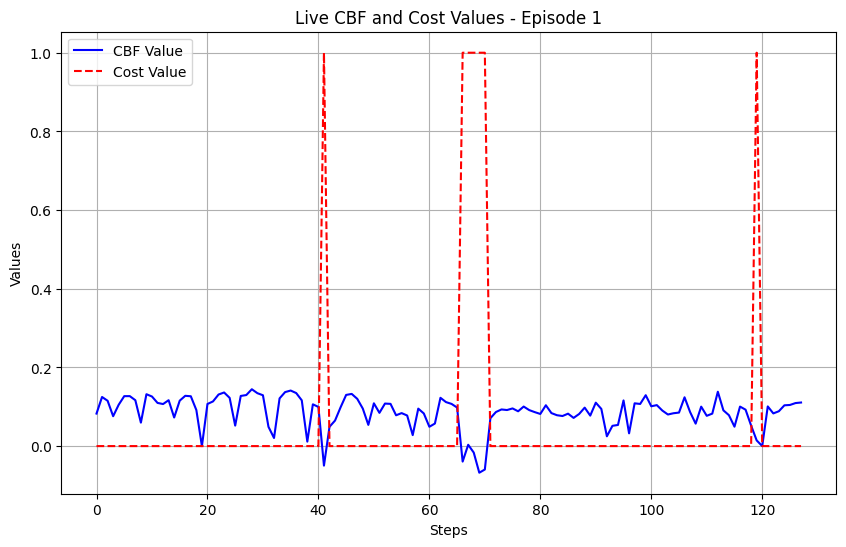

[-0.42928126  1.41825773 -1.53232595 -0.09076542 -0.52108021  0.66947443
 -0.95924719  0.07680253]
Episode 1 finished!
Simulation finished after 1 episodes.


In [93]:

##gd idk why
import torch
import json
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from IPython.display import display, clear_output
import time
from torch.utils.data import DataLoader
from osrl.common.exp_util import seed_all

# Assuming these imports are correct and the modules are available
from network_ihab import CombinedCBFDynamics
from dataset_ihab import TransitionDataset

# Load model and hyperparameters
model_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_217/combined_model.pth"
hyperparams_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_217/hyperparameters.json"

seed_all(112)

# Load hyperparameters
with open(hyperparams_path, 'r') as f:
    hyperparams = json.load(f)

# Initialize and load the model
combinedcbfdynamics = CombinedCBFDynamics(
    num_action=hyperparams['num_action'],
    state_dim=hyperparams['state_dim'],
    cbf_hidden_dim=hyperparams['cbf_hidden_dim'],
    dynamics_hidden_dim=hyperparams['dynamics_hidden_dim'],
    cbf_num_layers=hyperparams['cbf_num_layers'],
    dynamics_num_layers=hyperparams['dynamics_num_layers'],
    dt=hyperparams['dt']
)

checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
combinedcbfdynamics.load_state_dict(checkpoint)
combinedcbfdynamics.eval()
print("Model loaded successfully!")

# Initialize environment
env = gym.make('OfflineSwimmerVelocityGymnasium-v1')
dataset = env.get_dataset()
env = gym.make('SafetySwimmerVelocityGymnasium-v1')
# Process dataset (assuming these functions are defined elsewhere)
# env.set_target_cost(args.cost_limit)
# process_bc_dataset(dataset, args.cost_limit, args.gamma, args.bc_mode)

# Create a dataset and dataloader
dataset = TransitionDataset(dataset,split='val')
dataloader = DataLoader(dataset, batch_size=128)

# Get a batch of data
batch = next(iter(dataloader))
observations, next_observations, actions, _, costs, done = [b.to(torch.float32) for b in batch]

# Use the model to predict next states
with torch.no_grad():
    predicted_next_observations = combinedcbfdynamics.forward_next_state(observations, actions)
    cbf_values_batch = combinedcbfdynamics.forward_cbf(observations)

print("Sample observations:", observations[:5])
print("Sample CBF values:", cbf_values_batch[:5])
print("Sample costs:", costs[:5])

# Initialize data storage for plotting
cbf_values = []
cost_values = []
steps = []
episode_count = 0
max_episodes = 1

observation, info = env.reset()

while episode_count < max_episodes:
    for step_index in range(len(observations)):
        observation = obs_next
        action = actions[step_index].numpy()

        # Compute CBF value
        obs_tensor = torch.FloatTensor(observation).unsqueeze(0)
        with torch.no_grad():
            cbf_value = combinedcbfdynamics.forward_cbf(obs_tensor).item()

        # Step in the environment
        obs_next, reward, terminated, truncated, info = env.step(action)

        # Store history
        cbf_values.append(cbf_value)
        cost = info['cost']  # Use the cost from the dataset
        cost_values.append(cost)
        steps.append(step_index)

        # Update the plot dynamically
        clear_output(wait=True)
        plt.figure(figsize=(10, 6))
        plt.plot(steps, cbf_values, 'b-', label="CBF Value")
        plt.plot(steps, cost_values, 'r--', label="Cost Value")
        plt.xlabel('Steps')
        plt.ylabel('Values')
        plt.title(f'Live CBF and Cost Values - Episode {episode_count + 1}')
        plt.legend()
        plt.grid(True)
        display(plt.gcf())
        plt.close()

        # time.sleep(0.1)
        print(obs_next)
        if terminated or truncated:
            break

    episode_count += 1
    print(f"Episode {episode_count} finished!")
    observation, info = env.reset()

print(f"Simulation finished after {episode_count} episodes.")
env.close()


In [44]:
import torch
import json
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from IPython.display import display, clear_output
import time
from torch.utils.data import DataLoader
from osrl.common.exp_util import seed_all

# Assuming these imports are correct and the modules are available
from network_ihab import CombinedCBFDynamics
from dataset_ihab import TransitionDataset

# Load model and hyperparameters
model_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_217/combined_model.pth"
hyperparams_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_217/hyperparameters.json"

seed_all(112)

# Load hyperparameters
with open(hyperparams_path, 'r') as f:
    hyperparams = json.load(f)

# Initialize and load the model
combinedcbfdynamics = CombinedCBFDynamics(
    num_action=hyperparams['num_action'],
    state_dim=hyperparams['state_dim'],
    cbf_hidden_dim=hyperparams['cbf_hidden_dim'],
    dynamics_hidden_dim=hyperparams['dynamics_hidden_dim'],
    cbf_num_layers=hyperparams['cbf_num_layers'],
    dynamics_num_layers=hyperparams['dynamics_num_layers'],
    dt=hyperparams['dt']
)

checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
combinedcbfdynamics.load_state_dict(checkpoint)
combinedcbfdynamics.eval()
print("Model loaded successfully!")

# Initialize environment
env = gym.make('OfflineSwimmerVelocityGymnasium-v1')
dataset = env.get_dataset()
import safety_gymnasium as gym
env = gym.make('SafetySwimmerVelocity-v1')

# Create a dataset and dataloader
dataset = TransitionDataset(dataset, split='val')
dataloader = DataLoader(dataset, batch_size=128)

# Get a batch of data
batch = next(iter(dataloader))
observations, next_observations, actions, _, costs, done = [b.to(torch.float32) for b in batch]

# Use the model to predict next states
with torch.no_grad():
    predicted_next_observations = combinedcbfdynamics.forward_next_state(observations, actions)
    cbf_values_batch = combinedcbfdynamics.forward_cbf(observations)

print("Sample observations:", observations[:5])
print("Sample CBF values:", cbf_values_batch[:5])
print("Sample costs:", costs[:5])

# Initialize data storage for plotting
cbf_values = []
cost_values = []
steps = []
episode_count = 0
max_episodes = 1

# Start the environment
observation, info = env.reset(seed=112)

while episode_count < max_episodes:
    for step_index in range(len(observations)):
        action = actions[step_index].numpy()

        # Compute CBF value
        obs_tensor = torch.FloatTensor(observation).unsqueeze(0)
        with torch.no_grad():
            cbf_value = combinedcbfdynamics.forward_cbf(obs_tensor).item()

        # Step in the environment
        obs, reward, cost, terminated, truncated, info = env.step(action)
        # print(obs)
        # print("info",info)

        # Store history
        cbf_values.append(cbf_value)
        # cost = info.get('cost', 0)  # THIS WAS GIVING ME WRONG GRAPH BEFORE I COMMENTED IT # THIS WAS GIVING ME WRONG GRAPH BEFORE I COMMENTED IT # THIS WAS GIVING ME WRONG GRAPH BEFORE I COMMENTED IT # THIS WAS GIVING ME WRONG GRAPH BEFORE I COMMENTED IT
        ###HONE MAFI COST, WHEN I WRAP IT IF OFFLINE ENV YEMKIN BI SIR FI COST
        cost_values.append(cost)
        steps.append(step_index)

        # Update the plot dynamically
        clear_output(wait=True)
        plt.figure(figsize=(10, 6))
        plt.plot(steps, cbf_values, 'b-', label="CBF Value")
        plt.plot(steps, cost_values, 'r--', label="Cost Value")
        plt.xlabel('Steps')
        plt.ylabel('Values')
        plt.title(f'Live CBF and Cost Values - Episode {episode_count + 1}')
        plt.legend()
        plt.grid(True)
        display(plt.gcf())
        plt.close()

        # time.sleep(0.1)
        print(obs)

        # Update observation for the next step
        observation = obs

        if terminated or truncated:
            break

    episode_count += 1
    print(f"Episode {episode_count} finished!")
    observation, info = env.reset()

print(f"Simulation finished after {episode_count} episodes.")
env.close()




Model loaded successfully!
Loading dataset from /Users/i.k.tabbara/.dsrl/datasets/SafetySwimmerVelocityGymnasium-v1-200-1686.hdf5


load datafile: 100%|██████████| 7/7 [00:00<00:00, 11.26it/s]

Sample observations: tensor([[-2.6580e+00,  1.7461e+00,  9.1897e-01,  7.4871e-02,  6.2673e-02,
          1.2046e-01,  1.7890e-03, -3.6148e-01],
        [-2.3633e+00,  1.5062e+00,  7.2516e-01,  1.2982e+00, -9.5790e-01,
         -2.1560e+00,  2.1803e+00,  8.7001e-01],
        [ 2.6671e+00, -1.7466e+00, -1.7458e+00,  7.9168e-03,  4.3297e-02,
          7.0048e-02, -6.4134e-02, -1.0015e-02],
        [ 2.5944e+00, -1.7463e+00, -8.3340e-01,  7.2637e-02, -1.1002e-01,
         -2.1068e-01,  5.1167e-03,  6.4341e-01],
        [-2.5293e+00,  1.7460e+00,  8.8123e-01,  4.8015e-02,  6.3036e-02,
          1.0370e-01, -4.4018e-03, -2.9522e-01]])
Sample CBF values: tensor([[ 0.0797],
        [-0.1604],
        [ 0.0557],
        [ 0.0898],
        [ 0.0858]])
Sample costs: tensor([0., 1., 0., 0., 0.])


ValueError: not enough values to unpack (expected 6, got 5)

In [48]:
import torch
import json
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
import safety_gymnasium as safety_gym
from torch.utils.data import DataLoader
from osrl.common.exp_util import seed_all
from IPython.display import display, clear_output
%matplotlib inline

# Assuming these imports are correct and the modules are available
from network_ihab import CombinedCBFDynamics
from dataset_ihab import TransitionDataset

# Load model and hyperparameters
model_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_217/combined_model.pth"
hyperparams_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_217/hyperparameters.json"

# Set fixed seed for reproducibility
seed_all(112)

# Load hyperparameters
with open(hyperparams_path, 'r') as f:
    hyperparams = json.load(f)

# Initialize and load the model
combinedcbfdynamics = CombinedCBFDynamics(
    num_action=hyperparams['num_action'],
    state_dim=hyperparams['state_dim'],
    cbf_hidden_dim=hyperparams['cbf_hidden_dim'],
    dynamics_hidden_dim=hyperparams['dynamics_hidden_dim'],
    cbf_num_layers=hyperparams['cbf_num_layers'],
    dynamics_num_layers=hyperparams['dynamics_num_layers'],
    dt=hyperparams['dt']
)

checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
combinedcbfdynamics.load_state_dict(checkpoint)
combinedcbfdynamics.eval()
print("Model loaded successfully!")

# Initialize environment and get dataset from gymnasium
std_env = gym.make('OfflineSwimmerVelocityGymnasium-v1')
dataset = std_env.get_dataset()
std_env.close()

# Create a dataset and dataloader
dataset = TransitionDataset(dataset, split='val')
dataloader = DataLoader(dataset, batch_size=128)

# Get a batch of data
batch = next(iter(dataloader))
observations, next_observations, actions, _, costs, done = [b.to(torch.float32) for b in batch]

# Initialize data storage for plotting
cbf_values = []
cost_values = []
steps = []
all_observations = []
episode_count = 0
max_episodes = 1

# Create the Safety Gymnasium environment
env = safety_gym.make('SafetySwimmerVelocity-v1', render_mode=None)
observation, info = env.reset(seed=112)
# Start the environment

all_observations.append(observation)

print("Initial observation:", observation)

while episode_count < max_episodes:
    for step_index in range(len(actions)):
        action = actions[step_index].numpy()

        # Compute CBF value
        obs_tensor = torch.FloatTensor(observation).unsqueeze(0)
        with torch.no_grad():
            cbf_value = combinedcbfdynamics.forward_cbf(obs_tensor).item()

        # Step in the environment
        next_obs, reward, cost, terminated, truncated, info = env.step(action)
        all_observations.append(next_obs)

        print(info)
        # Store history
        cbf_values.append(cbf_value)
        cost_values.append(cost)
        steps.append(step_index)

        # Print current step information
        print(f"Step {step_index}:")
        print(f"  Action: {action}")
        print(f"  Observation: {next_obs}")
        print(f"  CBF Value: {cbf_value}")
        print(f"  Cost: {cost}")
        print("-------------------")

        # Update observation for the next step
        observation = next_obs

        if terminated or truncated:
            print("Episode terminated early")
            break

    episode_count += 1
    print(f"Episode {episode_count} finished!")

# Close the environment
env.close()

# ... (previous code remains the same)

# After closing the environment and before saving results

# Create and display overlapping plot
plt.figure(figsize=(12, 6))
plt.plot(steps, cbf_values, label='CBF Values', color='blue')
plt.plot(steps, cost_values, label='Cost Values', color='red')
plt.title('CBF Values and Cost Values over Steps')
plt.xlabel('Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# ... (rest of the code remains the same)

# Save results for comparison (optional)
results = {
    'steps': steps,
    'cbf_values': cbf_values,
    'cost_values': cost_values,
    'observations': all_observations
}

# Optionally save the results
import pickle
with open('safety_gymnasium_data.pkl', 'wb') as f:
    pickle.dump(results, f)

print("Results saved for comparison.")


Model loaded successfully!
Loading dataset from /Users/i.k.tabbara/.dsrl/datasets/SafetySwimmerVelocityGymnasium-v1-200-1686.hdf5


load datafile: 100%|██████████| 7/7 [00:00<00:00,  9.74it/s]

Initial observation: [ 0.05973468 -0.09652068 -0.08461066 -0.00070873  0.06541976 -0.04762023
 -0.03742139  0.04448135]
{'reward_fwd': -0.01032615277375519, 'reward_ctrl': -3.974077999591827e-05, 'x_position': -0.07712124350941914, 'y_position': 0.08549324029260381, 'distance_from_origin': 0.11513809246365002, 'x_velocity': -0.01032615277375519, 'y_velocity': 0.4165631423864075, 'forward_reward': -0.01032615277375519}
Step 0:
  Action: [0.61793184 0.12477195]
  Observation: [ 0.04319127 -0.07370399 -0.09515746 -0.01640731  0.75561663 -0.76645743
  1.1580728  -0.56407158]
  CBF Value: 0.12120559066534042
  Cost: 0.0
-------------------
{'reward_fwd': -0.01227887764063268, 'reward_ctrl': -0.00010276355743408204, 'x_position': -0.07761239861504445, 'y_position': 0.13608954252309716, 'distance_from_origin': 0.1566654014226703, 'x_velocity': -0.01227887764063268, 'y_velocity': 1.2649075557623335, 'forward_reward': -0.01227887764063268}
Step 1:
  Action: [1.         0.16623938]
  Observation

In [46]:

##gd idk why
##USING DATASET TO LOAD DATA THEN COST IS FROM ENV
import torch
import json
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from IPython.display import display, clear_output
import time
from torch.utils.data import DataLoader
from osrl.common.exp_util import seed_all

# Assuming these imports are correct and the modules are available
from network_ihab import CombinedCBFDynamics
from dataset_ihab import TransitionDataset

# Load model and hyperparameters
model_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_645/combined_model.pth"
hyperparams_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_645/hyperparameters.json"

seed_all(112)

# Load hyperparameters
with open(hyperparams_path, 'r') as f:
    hyperparams = json.load(f)

# Initialize and load the model
combinedcbfdynamics = CombinedCBFDynamics(
    num_action=hyperparams['num_action'],
    state_dim=hyperparams['state_dim'],
    cbf_hidden_dim=hyperparams['cbf_hidden_dim'],
    dynamics_hidden_dim=hyperparams['dynamics_hidden_dim'],
    cbf_num_layers=hyperparams['cbf_num_layers'],
    dynamics_num_layers=hyperparams['dynamics_num_layers'],
    dt=hyperparams['dt']
)

checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
combinedcbfdynamics.load_state_dict(checkpoint)
combinedcbfdynamics.eval()
print("Model loaded successfully!")

# Initialize environment

env = gym.make('OfflineSwimmerVelocityGymnasium-v1')#OfflineSwimmerVelocityGymnasium CONTAINS COST IN THE INFO. SafetySwimmerVelocity does not
dataset = env.get_dataset()

# Process dataset (assuming these functions are defined elsewhere)
# env.set_target_cost(args.cost_limit)
# process_bc_dataset(dataset, args.cost_limit, args.gamma, args.bc_mode)

# Create a dataset and dataloader
dataset = TransitionDataset(dataset,split='val')
dataloader = DataLoader(dataset, batch_size=400)##change this to make it longer

# Get a batch of data
batch = next(iter(dataloader))
observations, next_observations, actions, _, costs, done = [b.to(torch.float32) for b in batch]

# Use the model to predict next states
with torch.no_grad():
    predicted_next_observations = combinedcbfdynamics.forward_next_state(observations, actions)
    cbf_values_batch = combinedcbfdynamics.forward_cbf(observations)

print("Sample observations:", observations[:5])
print("Sample CBF values:", cbf_values_batch[:5])
print("Sample costs:", costs[:5])

# Initialize data storage for plotting
cbf_values = []
cost_values = []
steps = []
episode_count = 0
max_episodes = 1

observation, info = env.reset(seed=112)

while episode_count < max_episodes:
    for step_index in range(len(observations)):
        observation = obs_next
        action = actions[step_index].numpy()

        # Compute CBF value
        obs_tensor = torch.FloatTensor(observation).unsqueeze(0)
        with torch.no_grad():
            cbf_value = combinedcbfdynamics.forward_cbf(obs_tensor).item()

        # Step in the environment
        obs_next, reward, terminated, truncated, info = env.step(action)###USING ACTUAL OBSERVATION#USING ACTUAL OBSERVATION#USING ACTUAL OBSERVATION#USING ACTUAL OBSERVATION#USING ACTUAL OBSERVATION#USING ACTUAL OBSERVATION#USING ACTUAL OBSERVATION

        # Store history
        cbf_values.append(cbf_value)
        cost = info['cost']  # Use the cost from info of simulator
        
        cost_values.append(cost)
        steps.append(step_index)

        # Update the plot dynamically
        clear_output(wait=True)
        plt.figure(figsize=(10, 6))
        plt.plot(steps, cbf_values, 'b-', label="CBF Value")
        plt.plot(steps, cost_values, 'r--', label="Cost Value")
        plt.xlabel('Steps')
        plt.ylabel('Values')
        plt.title(f'Live CBF and Cost Values - Episode {episode_count + 1}')
        plt.legend()
        plt.grid(True)
        display(plt.gcf())
        plt.close()

        # time.sleep(0.1)

        if terminated or truncated:
            break

    episode_count += 1
    print(f"Episode {episode_count} finished!")
    observation, info = env.reset()

print(f"Simulation finished after {episode_count} episodes.")
env.close()


Model loaded successfully!
Loading dataset from /Users/i.k.tabbara/.dsrl/datasets/SafetySwimmerVelocityGymnasium-v1-200-1686.hdf5


load datafile: 100%|██████████| 7/7 [00:00<00:00, 11.22it/s]

Sample observations: tensor([[-2.6580e+00,  1.7461e+00,  9.1897e-01,  7.4871e-02,  6.2673e-02,
          1.2046e-01,  1.7890e-03, -3.6148e-01],
        [-2.3633e+00,  1.5062e+00,  7.2516e-01,  1.2982e+00, -9.5790e-01,
         -2.1560e+00,  2.1803e+00,  8.7001e-01],
        [ 2.6671e+00, -1.7466e+00, -1.7458e+00,  7.9168e-03,  4.3297e-02,
          7.0048e-02, -6.4134e-02, -1.0015e-02],
        [ 2.5944e+00, -1.7463e+00, -8.3340e-01,  7.2637e-02, -1.1002e-01,
         -2.1068e-01,  5.1167e-03,  6.4341e-01],
        [-2.5293e+00,  1.7460e+00,  8.8123e-01,  4.8015e-02,  6.3036e-02,
          1.0370e-01, -4.4018e-03, -2.9522e-01]])
Sample CBF values: tensor([[ 0.1067],
        [-0.1483],
        [ 0.0665],
        [ 0.1094],
        [ 0.1126]])
Sample costs: tensor([0., 1., 0., 0., 0.])
{'reward_fwd': -0.01032615277375519, 'reward_ctrl': -3.974077999591827e-05, 'x_position': -0.07712124350941914, 'y_position': 0.08549324029260381, 'distance_from_origin': 0.11513809246365002, 'x_velocity':

Model loaded successfully!
Loading dataset from /Users/i.k.tabbara/.dsrl/datasets/SafetySwimmerVelocityGymnasium-v1-200-1686.hdf5


load datafile: 100%|██████████| 7/7 [00:00<00:00,  8.77it/s]

Initial observation: [ 0.05973468 -0.09652068 -0.08461066 -0.00070873  0.06541976 -0.04762023
 -0.03742139  0.04448135]
{'reward_fwd': -0.01032615277375519, 'reward_ctrl': -3.974077999591827e-05, 'x_position': -0.07712124350941914, 'y_position': 0.08549324029260381, 'distance_from_origin': 0.11513809246365002, 'x_velocity': -0.01032615277375519, 'y_velocity': 0.4165631423864075, 'forward_reward': -0.01032615277375519}
Step 0:
  Action: [0.61793184 0.12477195]
  Observation: [ 0.04319127 -0.07370399 -0.09515746 -0.01640731  0.75561663 -0.76645743
  1.1580728  -0.56407158]
  CBF Value: 0.12120559066534042
  Cost: 0.0
-------------------
{'reward_fwd': -0.01227887764063268, 'reward_ctrl': -0.00010276355743408204, 'x_position': -0.07761239861504445, 'y_position': 0.13608954252309716, 'distance_from_origin': 0.1566654014226703, 'x_velocity': -0.01227887764063268, 'y_velocity': 1.2649075557623335, 'forward_reward': -0.01227887764063268}
Step 1:
  Action: [1.         0.16623938]
  Observation

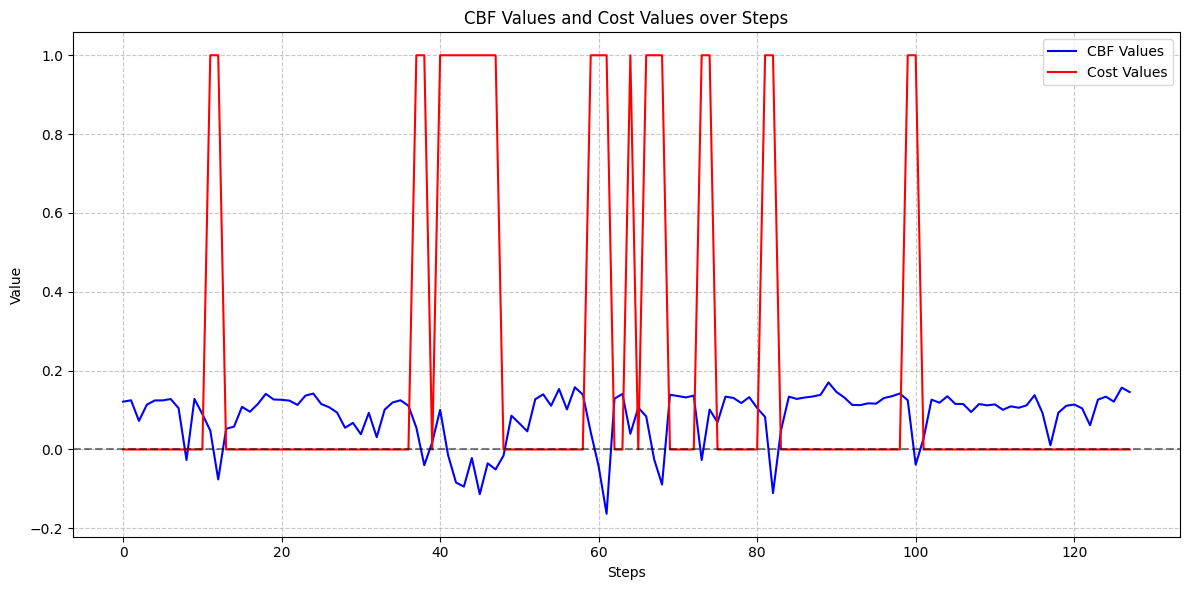

Results saved for comparison.


Model loaded successfully!
Loading dataset from /Users/i.k.tabbara/.dsrl/datasets/SafetySwimmerVelocityGymnasium-v1-200-1686.hdf5


load datafile: 100%|██████████| 7/7 [00:00<00:00, 11.43it/s]


Initial observation: [ 0.05973468 -0.09652068 -0.08461066 -0.00070873  0.06541976 -0.04762023
 -0.03742139  0.04448135]
{'reward_fwd': -0.01032615277375519, 'reward_ctrl': -3.974077999591827e-05, 'x_position': -0.07712124350941914, 'y_position': 0.08549324029260381, 'distance_from_origin': 0.11513809246365002, 'x_velocity': -0.01032615277375519, 'y_velocity': 0.4165631423864075, 'forward_reward': -0.01032615277375519, 'cost': 0.0}
Step 0:
  Action: [0.61793184 0.12477195]
  Observation: [ 0.04319127 -0.07370399 -0.09515746 -0.01640731  0.75561663 -0.76645743
  1.1580728  -0.56407158]
  CBF Value: 0.12120559066534042
  Cost: 0.0
-------------------
{'reward_fwd': -0.01227887764063268, 'reward_ctrl': -0.00010276355743408204, 'x_position': -0.07761239861504445, 'y_position': 0.13608954252309716, 'distance_from_origin': 0.1566654014226703, 'x_velocity': -0.01227887764063268, 'y_velocity': 1.2649075557623335, 'forward_reward': -0.01227887764063268, 'cost': 0.0}
Step 1:
  Action: [1.        

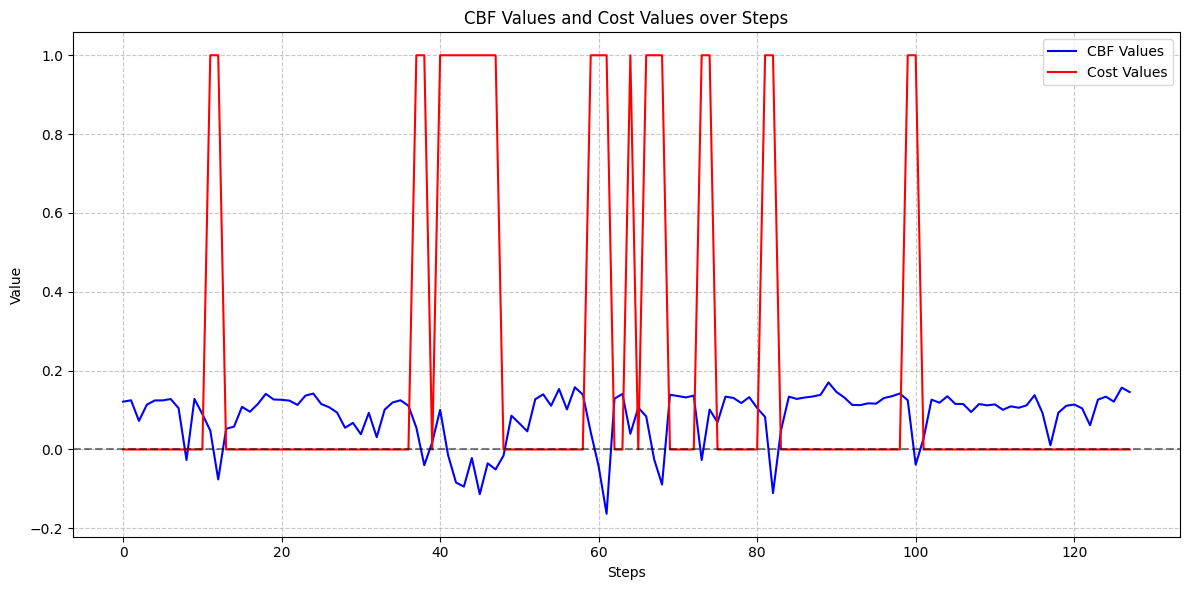

Results saved for comparison.


In [75]:
import torch
import json
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
import safety_gymnasium as safety_gym
from torch.utils.data import DataLoader
from osrl.common.exp_util import seed_all
from IPython.display import display, clear_output
from dsrl.offline_env import OfflineEnvWrapper, wrap_env  # noqa
%matplotlib inline

# Assuming these imports are correct and the modules are available
from network_ihab import CombinedCBFDynamics
from dataset_ihab import TransitionDataset

# Load model and hyperparameters
model_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_217/combined_model.pth"
hyperparams_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_217/hyperparameters.json"

# Set fixed seed for reproducibility
seed_all(112)

# Load hyperparameters
with open(hyperparams_path, 'r') as f:
    hyperparams = json.load(f)

# Initialize and load the model
combinedcbfdynamics = CombinedCBFDynamics(
    num_action=hyperparams['num_action'],
    state_dim=hyperparams['state_dim'],
    cbf_hidden_dim=hyperparams['cbf_hidden_dim'],
    dynamics_hidden_dim=hyperparams['dynamics_hidden_dim'],
    cbf_num_layers=hyperparams['cbf_num_layers'],
    dynamics_num_layers=hyperparams['dynamics_num_layers'],
    dt=hyperparams['dt']
)

checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
combinedcbfdynamics.load_state_dict(checkpoint)
combinedcbfdynamics.eval()
print("Model loaded successfully!")

# Initialize environment and get dataset from gymnasium
std_env = gym.make('OfflineSwimmerVelocityGymnasium-v1')
dataset = std_env.get_dataset()
std_env.close()

# Create a dataset and dataloader
dataset = TransitionDataset(dataset, split='val')
dataloader = DataLoader(dataset, batch_size=128)

# Get a batch of data
batch = next(iter(dataloader))
observations, next_observations, actions, _, costs, done = [b.to(torch.float32) for b in batch]

# Initialize data storage for plotting
cbf_values = []
cost_values = []
steps = []
all_observations = []
episode_count = 0
max_episodes = 1

# Create the Safety Gymnasium environment
# env = safety_gym.make('SafetySwimmerVelocity-v1', render_mode=None)
env = wrap_env(
        env=gym.make("SafetySwimmerVelocityGymnasium-v1", render_mode="human"))
observation, info = env.reset(seed=112)
# Start the environment

all_observations.append(observation)

print("Initial observation:", observation)

while episode_count < max_episodes:
    for step_index in range(len(actions)):
        action = actions[step_index].numpy()

        # Compute CBF value
        obs_tensor = torch.FloatTensor(observation).unsqueeze(0)
        with torch.no_grad():
            cbf_value = combinedcbfdynamics.forward_cbf(obs_tensor).item()

        # Step in the environment
        next_obs, reward, terminated, truncated, info  = env.step(action)
       # obs_next, reward, terminated, truncated, info 
        all_observations.append(next_obs)

        print(info)
        # Store history
        cbf_values.append(cbf_value)
        cost_values.append(info["cost"])
        steps.append(step_index)

        # Print current step information
        print(f"Step {step_index}:")
        print(f"  Action: {action}")
        print(f"  Observation: {next_obs}")
        print(f"  CBF Value: {cbf_value}")
        print(f"  Cost: {cost}")
        print("-------------------")

        # Update observation for the next step
        observation = next_obs

        if terminated or truncated:
            print("Episode terminated early")
            break

    episode_count += 1
    print(f"Episode {episode_count} finished!")

# Close the environment
env.close()

# ... (previous code remains the same)

# After closing the environment and before saving results

# Create and display overlapping plot
plt.figure(figsize=(12, 6))
plt.plot(steps, cbf_values, label='CBF Values', color='blue')
plt.plot(steps, cost_values, label='Cost Values', color='red')
plt.title('CBF Values and Cost Values over Steps')
plt.xlabel('Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# ... (rest of the code remains the same)

# Save results for comparison (optional)
results = {
    'steps': steps,
    'cbf_values': cbf_values,
    'cost_values': cost_values,
    'observations': all_observations
}

# Optionally save the results
import pickle
with open('safety_gymnasium_data.pkl', 'wb') as f:
    pickle.dump(results, f)

print("Results saved for comparison.")


wrapper doesnt matter much. lfare2 enno safety gymnasium returns cost explicitly bas gym returns it bel info. 
both can be defined using safety... or offline... and lfare2 eno we7de we can render we7de la2

because of DSRL we are able to create these envs in gymnasium rather than safety gymnasium


Model loaded successfully!
Loading dataset from /Users/i.k.tabbara/.dsrl/datasets/SafetySwimmerVelocityGymnasium-v1-200-1686.hdf5


load datafile: 100%|██████████| 7/7 [00:00<00:00, 10.71it/s]

Initial observation: [ 0.05973468 -0.09652068 -0.08461066 -0.00070873  0.06541976 -0.04762023
 -0.03742139  0.04448135]
{'reward_fwd': -0.01032615277375519, 'reward_ctrl': -3.974077999591827e-05, 'x_position': -0.07712124350941914, 'y_position': 0.08549324029260381, 'distance_from_origin': 0.11513809246365002, 'x_velocity': -0.01032615277375519, 'y_velocity': 0.4165631423864075, 'forward_reward': -0.01032615277375519, 'cost': 0.0}
Step 0:
  Action: [0.61793184 0.12477195]
  Observation: [ 0.04319127 -0.07370399 -0.09515746 -0.01640731  0.75561663 -0.76645743
  1.1580728  -0.56407158]
  CBF Value: 0.30865105986595154
  Cost: 0.0
-------------------
{'reward_fwd': -0.01227887764063268, 'reward_ctrl': -0.00010276355743408204, 'x_position': -0.07761239861504445, 'y_position': 0.13608954252309716, 'distance_from_origin': 0.1566654014226703, 'x_velocity': -0.01227887764063268, 'y_velocity': 1.2649075557623335, 'forward_reward': -0.01227887764063268, 'cost': 0.0}
Step 1:
  Action: [1.        

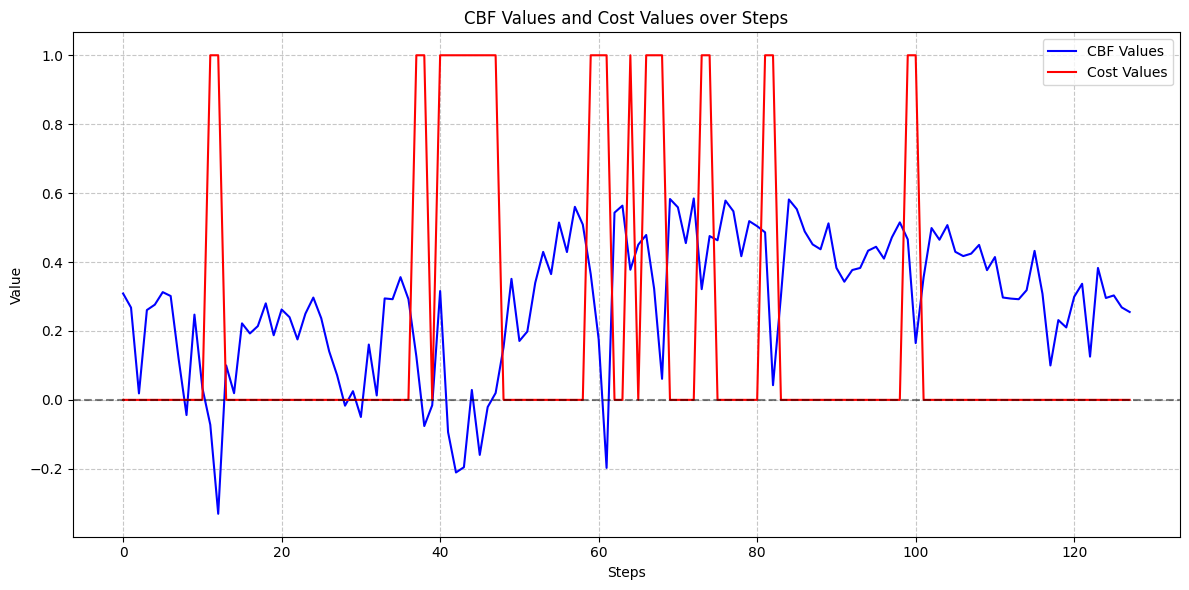

Results saved for comparison.


In [7]:
import torch
import json
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
import safety_gymnasium as safety_gym
from torch.utils.data import DataLoader
from osrl.common.exp_util import seed_all
from IPython.display import display, clear_output
from dsrl.offline_env import OfflineEnvWrapper, wrap_env  # noqa
%matplotlib inline

# Assuming these imports are correct and the modules are available
from network_ihab import CombinedCBFDynamics
from dataset_ihab import TransitionDataset

# Load model and hyperparameters
model_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_217/combined_model.pth"
hyperparams_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_217/hyperparameters.json"

# Set fixed seed for reproducibility
seed_all(112)

# Load hyperparameters
with open(hyperparams_path, 'r') as f:
    hyperparams = json.load(f)

# Initialize and load the model
combinedcbfdynamics = CombinedCBFDynamics(
    num_action=hyperparams['num_action'],
    state_dim=hyperparams['state_dim'],
    cbf_hidden_dim=hyperparams['cbf_hidden_dim'],
    dynamics_hidden_dim=hyperparams['dynamics_hidden_dim'],
    cbf_num_layers=hyperparams['cbf_num_layers'],
    dynamics_num_layers=hyperparams['dynamics_num_layers'],
    dt=hyperparams['dt']
)

checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
combinedcbfdynamics.load_state_dict(checkpoint)
combinedcbfdynamics.eval()
print("Model loaded successfully!")

# Initialize environment and get dataset from gymnasium
std_env = gym.make('OfflineSwimmerVelocityGymnasium-v1')
dataset = std_env.get_dataset()
std_env.close()

# Create a dataset and dataloader
dataset = TransitionDataset(dataset, split='val')
dataloader = DataLoader(dataset, batch_size=128)

# Get a batch of data
batch = next(iter(dataloader))
observations, next_observations, actions, _, costs, done = [b.to(torch.float32) for b in batch]

# Initialize data storage for plotting
cbf_values = []
cost_values = []
steps = []
all_observations = []
episode_count = 0
max_episodes = 1

# Create the Safety Gymnasium environment
# env = safety_gym.make('SafetySwimmerVelocity-v1', render_mode=None)

env=gym.make("OfflineSwimmerVelocityGymnasium-v1") #same as env = wrap_env(gym.make("OfflineSwimmerVelocityGymnasium-v1"))
observation, info = env.reset(seed=112)
# Start the environment

all_observations.append(observation)

print("Initial observation:", observation)

while episode_count < max_episodes:
    for step_index in range(len(actions)):
        action = actions[step_index].numpy()

        # Compute CBF value
        obs_tensor = torch.FloatTensor(observation).unsqueeze(0)
        with torch.no_grad():
            cbf_value = combinedcbfdynamics.forward_cbf(obs_tensor).item()

        # Step in the environment
        next_obs, reward, terminated, truncated, info  = env.step(action)
       # obs_next, reward, terminated, truncated, info 
        all_observations.append(next_obs)

        print(info)
        # Store history
        cbf_values.append(cbf_value)
        cost_values.append(info["cost"])
        steps.append(step_index)

        # Print current step information
        print(f"Step {step_index}:")
        print(f"  Action: {action}")
        print(f"  Observation: {next_obs}")
        print(f"  CBF Value: {cbf_value}")
        print(f"  Cost: {cost}")
        print("-------------------")

        # Update observation for the next step
        observation = next_obs

        if terminated or truncated:
            print("Episode terminated early")
            break

    episode_count += 1
    print(f"Episode {episode_count} finished!")

# Close the environment
env.close()

# ... (previous code remains the same)

# After closing the environment and before saving results

# Create and display overlapping plot
plt.figure(figsize=(12, 6))
plt.plot(steps, cbf_values, label='CBF Values', color='blue')
plt.plot(steps, cost_values, label='Cost Values', color='red')
plt.title('CBF Values and Cost Values over Steps')
plt.xlabel('Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# ... (rest of the code remains the same)

# Save results for comparison (optional)
results = {
    'steps': steps,
    'cbf_values': cbf_values,
    'cost_values': cost_values,
    'observations': all_observations
}

# Optionally save the results
import pickle
with open('safety_gymnasium_data.pkl', 'wb') as f:
    pickle.dump(results, f)

print("Results saved for comparison.")


Model loaded successfully!
Loading dataset from /Users/i.k.tabbara/.dsrl/datasets/SafetySwimmerVelocityGymnasium-v1-200-1686.hdf5


load datafile: 100%|██████████| 7/7 [00:00<00:00,  8.59it/s]

Initial observation: [ 0.05973468 -0.09652068 -0.08461066 -0.00070873  0.06541976 -0.04762023
 -0.03742139  0.04448135]
{'reward_fwd': -0.01032615277375519, 'reward_ctrl': -3.974077999591827e-05, 'x_position': -0.07712124350941914, 'y_position': 0.08549324029260381, 'distance_from_origin': 0.11513809246365002, 'x_velocity': -0.01032615277375519, 'y_velocity': 0.4165631423864075, 'forward_reward': -0.01032615277375519}
Step 0:
  Action: [0.61793184 0.12477195]
  Observation: [ 0.04319127 -0.07370399 -0.09515746 -0.01640731  0.75561663 -0.76645743
  1.1580728  -0.56407158]
  CBF Value: 0.12120559066534042
  Cost: 0.0
-------------------
{'reward_fwd': -0.01227887764063268, 'reward_ctrl': -0.00010276355743408204, 'x_position': -0.07761239861504445, 'y_position': 0.13608954252309716, 'distance_from_origin': 0.1566654014226703, 'x_velocity': -0.01227887764063268, 'y_velocity': 1.2649075557623335, 'forward_reward': -0.01227887764063268}
Step 1:
  Action: [1.         0.16623938]
  Observation

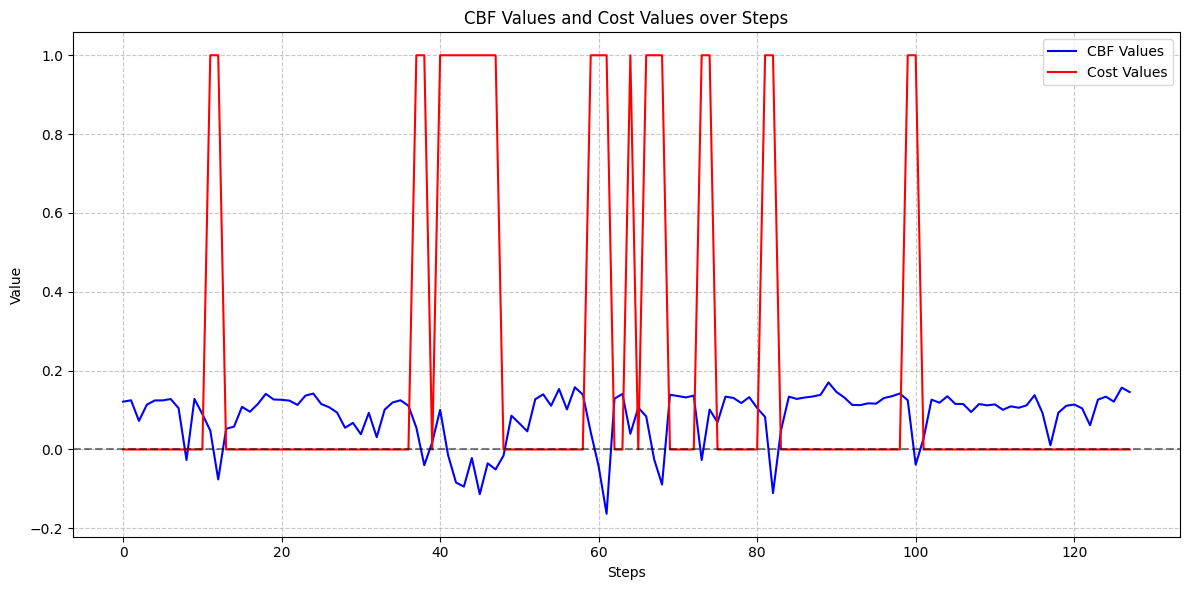

Results saved for comparison.


In [68]:
import torch
import json
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
import safety_gymnasium as safety_gym
from torch.utils.data import DataLoader
from osrl.common.exp_util import seed_all
from IPython.display import display, clear_output
%matplotlib inline

# Assuming these imports are correct and the modules are available
from network_ihab import CombinedCBFDynamics
from dataset_ihab import TransitionDataset

# Load model and hyperparameters
model_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_217/combined_model.pth"
hyperparams_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_217/hyperparameters.json"

# Set fixed seed for reproducibility
seed_all(112)

# Load hyperparameters
with open(hyperparams_path, 'r') as f:
    hyperparams = json.load(f)

# Initialize and load the model
combinedcbfdynamics = CombinedCBFDynamics(
    num_action=hyperparams['num_action'],
    state_dim=hyperparams['state_dim'],
    cbf_hidden_dim=hyperparams['cbf_hidden_dim'],
    dynamics_hidden_dim=hyperparams['dynamics_hidden_dim'],
    cbf_num_layers=hyperparams['cbf_num_layers'],
    dynamics_num_layers=hyperparams['dynamics_num_layers'],
    dt=hyperparams['dt']
)

checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
combinedcbfdynamics.load_state_dict(checkpoint)
combinedcbfdynamics.eval()
print("Model loaded successfully!")

# Initialize environment and get dataset from gymnasium
std_env = gym.make('OfflineSwimmerVelocityGymnasium-v1')
dataset = std_env.get_dataset()
std_env.close()

# Create a dataset and dataloader
dataset = TransitionDataset(dataset, split='val')
dataloader = DataLoader(dataset, batch_size=128)

# Get a batch of data
batch = next(iter(dataloader))
observations, next_observations, actions, _, costs, done = [b.to(torch.float32) for b in batch]

# Initialize data storage for plotting
cbf_values = []
cost_values = []
steps = []
all_observations = []
episode_count = 0
max_episodes = 1

# Create the Safety Gymnasium environment
env = safety_gym.make('OfflineSwimmerVelocity-v1', render_mode=None)
observation, info = env.reset(seed=112)
# Start the environment

all_observations.append(observation)

print("Initial observation:", observation)

while episode_count < max_episodes:
    for step_index in range(len(actions)):
        action = actions[step_index].numpy()

        # Compute CBF value
        obs_tensor = torch.FloatTensor(observation).unsqueeze(0)
        with torch.no_grad():
            cbf_value = combinedcbfdynamics.forward_cbf(obs_tensor).item()

        # Step in the environment
        next_obs, reward, cost, terminated, truncated, info = env.step(action)
       # obs_next, reward, terminated, truncated, info 
        all_observations.append(next_obs)

        print(info)
        # Store history
        cbf_values.append(cbf_value)
        cost_values.append(cost)
        steps.append(step_index)

        # Print current step information
        print(f"Step {step_index}:")
        print(f"  Action: {action}")
        print(f"  Observation: {next_obs}")
        print(f"  CBF Value: {cbf_value}")
        print(f"  Cost: {cost}")
        print("-------------------")

        # Update observation for the next step
        observation = next_obs

        if terminated or truncated:
            print("Episode terminated early")
            break

    episode_count += 1
    print(f"Episode {episode_count} finished!")

# Close the environment
env.close()

# ... (previous code remains the same)

# After closing the environment and before saving results

# Create and display overlapping plot
plt.figure(figsize=(12, 6))
plt.plot(steps, cbf_values, label='CBF Values', color='blue')
plt.plot(steps, cost_values, label='Cost Values', color='red')
plt.title('CBF Values and Cost Values over Steps')
plt.xlabel('Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# ... (rest of the code remains the same)

# Save results for comparison (optional)
results = {
    'steps': steps,
    'cbf_values': cbf_values,
    'cost_values': cost_values,
    'observations': all_observations
}

# Optionally save the results
import pickle
with open('safety_gymnasium_data.pkl', 'wb') as f:
    pickle.dump(results, f)

print("Results saved for comparison.")


Model loaded successfully!
Loading dataset from /Users/i.k.tabbara/.dsrl/datasets/SafetySwimmerVelocityGymnasium-v1-200-1686.hdf5


load datafile: 100%|██████████| 7/7 [00:00<00:00, 10.34it/s]

Initial observation: [ 0.05973468 -0.09652068 -0.08461066 -0.00070873  0.06541976 -0.04762023
 -0.03742139  0.04448135]
Episode 1 finished!


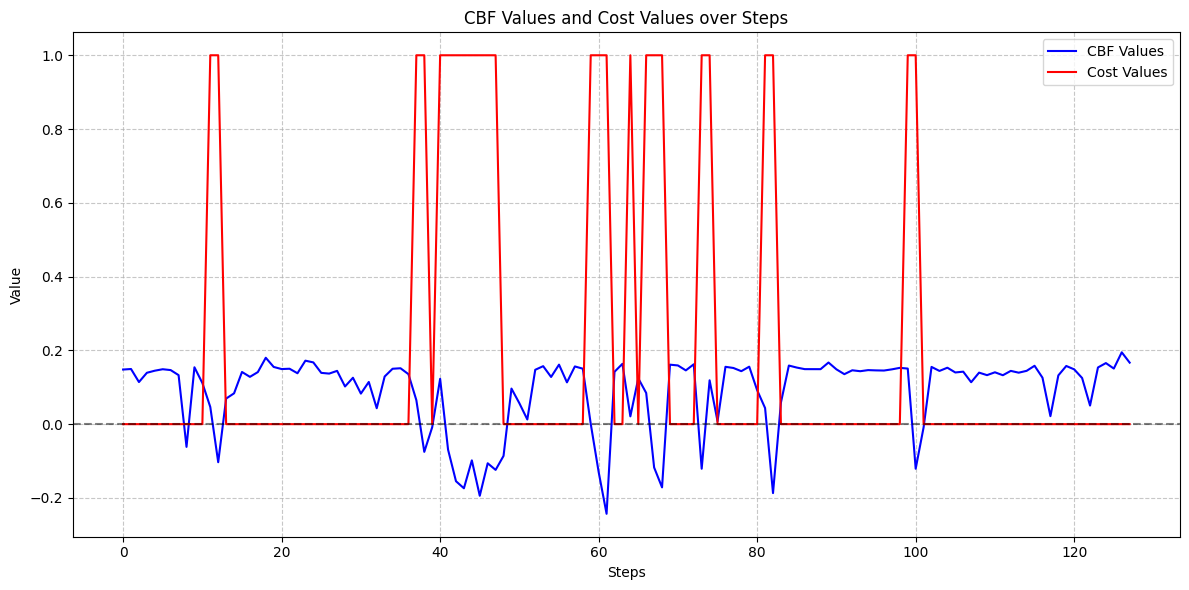

Results saved for comparison.


In [9]:
import torch
import json
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
import safety_gymnasium as safety_gym
from torch.utils.data import DataLoader
from osrl.common.exp_util import seed_all
from IPython.display import display, clear_output
%matplotlib inline

# Assuming these imports are correct and the modules are available
from network_ihab import CombinedCBFDynamics
from dataset_ihab import TransitionDataset

# Load model and hyperparameters
# model_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_217/combined_model.pth"
# hyperparams_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_217/hyperparameters.json"
model_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_202/combined_model.pth"
hyperparams_path = "/Users/i.k.tabbara/Documents/python directory/OSRL/examples/research/models/OfflineSwimmerVelocityGymnasium-v1_202/hyperparameters.json"

# Set fixed seed for reproducibility
seed_all(112)

# Load hyperparameters
with open(hyperparams_path, 'r') as f:
    hyperparams = json.load(f)

# Initialize and load the model
combinedcbfdynamics = CombinedCBFDynamics(
    num_action=hyperparams['num_action'],
    state_dim=hyperparams['state_dim'],
    cbf_hidden_dim=hyperparams['cbf_hidden_dim'],
    dynamics_hidden_dim=hyperparams['dynamics_hidden_dim'],
    cbf_num_layers=hyperparams['cbf_num_layers'],
    dynamics_num_layers=hyperparams['dynamics_num_layers'],
    dt=hyperparams['dt']
)

checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
combinedcbfdynamics.load_state_dict(checkpoint)
combinedcbfdynamics.eval()
print("Model loaded successfully!")

# Initialize environment and get dataset from gymnasium
std_env = gym.make('OfflineSwimmerVelocityGymnasium-v1')
dataset = std_env.get_dataset()
std_env.close()

# Create a dataset and dataloader
dataset = TransitionDataset(dataset, split='val')
dataloader = DataLoader(dataset, batch_size=128)

# Get a batch of data
batch = next(iter(dataloader))
observations, next_observations, actions, _, costs, done = [b.to(torch.float32) for b in batch]

# Initialize data storage for plotting
cbf_values = []
cost_values = []
steps = []
all_observations = []
episode_count = 0
max_episodes = 1

# Create the Safety Gymnasium environment
env = safety_gym.make('SafetySwimmerVelocity-v1', render_mode=None)
observation, info = env.reset(seed=112)
# Start the environment

all_observations.append(observation)

print("Initial observation:", observation)

while episode_count < max_episodes:
    for step_index in range(len(actions)):
        action = actions[step_index].numpy()

        # Compute CBF value
        obs_tensor = torch.FloatTensor(observation).unsqueeze(0)
        with torch.no_grad():
            cbf_value = combinedcbfdynamics.forward_cbf(obs_tensor).item()

        # Step in the environment
        next_obs, reward, cost, terminated, truncated, info = env.step(action)
       # obs_next, reward, terminated, truncated, info 
        all_observations.append(next_obs)

        # print(info)
        # Store history
        cbf_values.append(cbf_value)
        cost_values.append(cost)
        steps.append(step_index)

        # Print current step information
        # print(f"Step {step_index}:")
        # print(f"  Action: {action}")
        # print(f"  Observation: {next_obs}")
        # print(f"  CBF Value: {cbf_value}")
        # print(f"  Cost: {cost}")
        # print("-------------------")

        # Update observation for the next step
        observation = next_obs

        if terminated or truncated:
            print("Episode terminated early")
            break

    episode_count += 1
    print(f"Episode {episode_count} finished!")

# Close the environment
env.close()

# ... (previous code remains the same)

# After closing the environment and before saving results

# Create and display overlapping plot
plt.figure(figsize=(12, 6))
plt.plot(steps, cbf_values, label='CBF Values', color='blue')
plt.plot(steps, cost_values, label='Cost Values', color='red')
plt.title('CBF Values and Cost Values over Steps')
plt.xlabel('Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# ... (rest of the code remains the same)

# Save results for comparison (optional)
results = {
    'steps': steps,
    'cbf_values': cbf_values,
    'cost_values': cost_values,
    'observations': all_observations
}

# Optionally save the results
import pickle
with open('safety_gymnasium_data.pkl', 'wb') as f:
    pickle.dump(results, f)

print("Results saved for comparison.")


In [1]:
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("i-k-tabbara-washington-university-in-st-louis/combined_cbf_dynamics_training")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

runs_df.to_csv("project.csv")

In [ ]:
#safety gymnasium compute brs